In [1]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [2]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

In [3]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [4]:
bs = 192
wd = 1e-1
moms = (0.8,0.7,0.8) # (0.95, 0.85, 0.95)#
seq_len = 72

In [5]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_data_fwd'
text_path = data_path/name
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

In [6]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [7]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

7984

In [8]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
full_df = pd.concat([train_df,test_df], sort=False)
full_df = full_df.rename(columns={'comment': 'text'})
full_df = full_df.drop_duplicates('text')
full_df.head()

,text,label
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד צער,0
1,איש יקר שלנו,0
2,כל הכבוד והמון בהצלחה,0
3,"תל חי , רובי . בכל העצב הזה היית קרן אור של תקוה . אכן יש נשיא בישראל",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0


In [9]:
tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
splits = RandomSplitter(valid_pct=0.1, seed=42)(full_df)
dsrc = Datasets(full_df, [tfms], splits=splits, dl_type=LMDataLoader)
data_ft = dsrc.dataloaders(bs=bs, seq_len=seq_len,
                           cache=2048, num_workers=8, pin_memory=True)

In [10]:
opt_func = partial(Adam)
learn_lm = language_model_learner(data_ft, AWD_QRNN, metrics=[accuracy, Perplexity()], path=path,
                                  opt_func = opt_func,
                                  drop_mult=0.8, pretrained_fnames=lm_fns)
learn_lm.loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.04786301031708717)

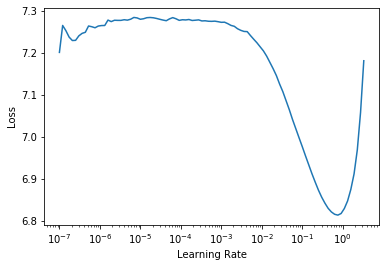

In [11]:
learn_lm.lr_find()

In [12]:
lr = 2e-1
n_epochs = 15
# lr *= bs/48  # Scale learning rate by batch size

In [13]:
learn_lm.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms, div=10, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.543953,5.660921,0.185812,287.413269,00:09
1,6.124665,5.509095,0.198495,246.927490,00:09
2,5.931855,5.578690,0.188706,264.724487,00:09
3,5.838555,5.603178,0.189429,271.287079,00:09
4,5.791818,5.622249,0.186150,276.510590,00:09
5,5.746021,5.589795,0.191286,267.680634,00:09
6,5.701417,5.574423,0.191623,263.597504,00:09
7,5.656559,5.535598,0.199822,253.559326,00:09
8,5.603333,5.496658,0.200521,243.875504,00:09
9,5.552659,5.463511,0.203246,235.924408,00:09


SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.5848931980144698e-06)

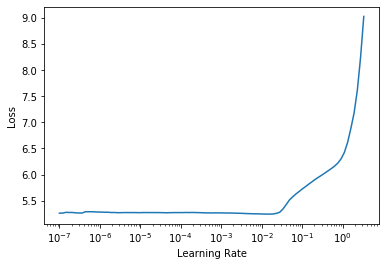

In [14]:
learn_lm.unfreeze()
learn_lm.lr_find()

In [15]:
lr = 5e-3
learn_lm.fit_one_cycle(2*n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=10, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.271056,5.367859,0.213710,214.403412,00:11
1,5.250353,5.360577,0.214000,212.847641,00:11
2,5.229568,5.355512,0.216242,211.772308,00:11
3,5.205168,5.349333,0.219015,210.467834,00:11
4,5.182096,5.336025,0.220414,207.685471,00:11
5,5.148757,5.321509,0.221595,204.692505,00:11
6,5.118629,5.316768,0.222174,203.724411,00:11
7,5.089879,5.311641,0.223356,202.682602,00:11
8,5.060056,5.312539,0.223597,202.864670,00:11
9,5.029198,5.296241,0.225719,199.585114,00:11


In [16]:
#11	4.921030	5.206492	0.232639	182.452881	00:11

In [17]:
# learn_lm.save(f'{lang}fine_tuned_{tok}_{data_format}')
# learn_lm.save_encoder(f'{lang}fine_tuned_enc_{tok}_{data_format}')